In [24]:
# Data-handling libraries
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# Network libraries
import networkx as nx
import netwulf as nw

In [2]:
# Load formatted book (dict of chapters with list of lists of pages and sentences)
with open("1.Dataset_files/Books_formatted/Book1.pkl","rb") as f:
    book = pkl.load(f)

print(f" Number of chapters: {len(book)}, number of pages: {sum([len(chapter) for chapter in book.values()])}, number of sentences: {sum([sum([len(page) for page in chapter]) for chapter in book.values()])}")

# Load characters wiki
character_df = pd.read_csv("1.Dataset_files/CharacterWikis.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]
character_df.Tokens = [eval(t) for t in character_df.Tokens]

# dict so we have all nodes (list of dicts of all character names (str) and their aliases (list of str)))
characters = [{'name':character_df['Name'].iloc[i], 'aliases': char + [character_df['Name'].iloc[i]]} for i, char in enumerate(character_df.Aliases)]

print(f" Number of characters: {len(characters)}, number of aliases: {sum([len(char['aliases']) for char in characters])}")

 Number of chapters: 17, number of pages: 347, number of sentences: 4929
 Number of characters: 707, number of aliases: 1392


In [12]:
def get_edge_chapter_weight(character1: list, character2: list, chapter: list):
    weight = 0
    for page in chapter:
        page_text = ' '.join(page)
        if any([char in page_text for char in character1]) and any([char in page_text for char in character2]):
                weight += 1
    
    return weight

def get_edge_book_weight(character1: list, character2: list, book: dict):
    weight = defaultdict(int)
    for chapternr in range(1, len(book)+1):
        weight[chapternr] = get_edge_chapter_weight(character1, character2, book[chapternr])
    return weight

def get_node_size(character: list, book: dict):
    size = defaultdict(int)
    for chapternr, chapter  in book.items():
        for page in chapter:
            page_text = ' '.join(page)
            if any([char in page_text for char in character]):
                size[chapternr] += 1
    return size

In [27]:
# Draw network
G = nx.Graph()

# Add nodes to graph
for character in tqdm(characters, desc='Adding character nodes to graph...'):
    character['sizes'] = get_node_size(character['aliases'], book)
    G.add_node(character['name'], sizes=character['sizes'], attr=character['aliases'])

# Add edges to graph
for i, char1 in enumerate(tqdm(characters, desc='Adding edges to graph...')):
    for j, char2 in enumerate(characters[i+1:]):
        edge_weight = get_edge_book_weight(char1['aliases'], char2['aliases'], book)
        if sum(edge_weight.values()) != 0:
            G.add_edge(char1['name'], char2['name'], weight=edge_weight)

Adding edges to graph...: 100%|██████████| 707/707 [09:03<00:00,  1.30it/s]


In [84]:
len(G.nodes), len(characters) # why are the number of nodes different from the number of characters?

(697, 707)

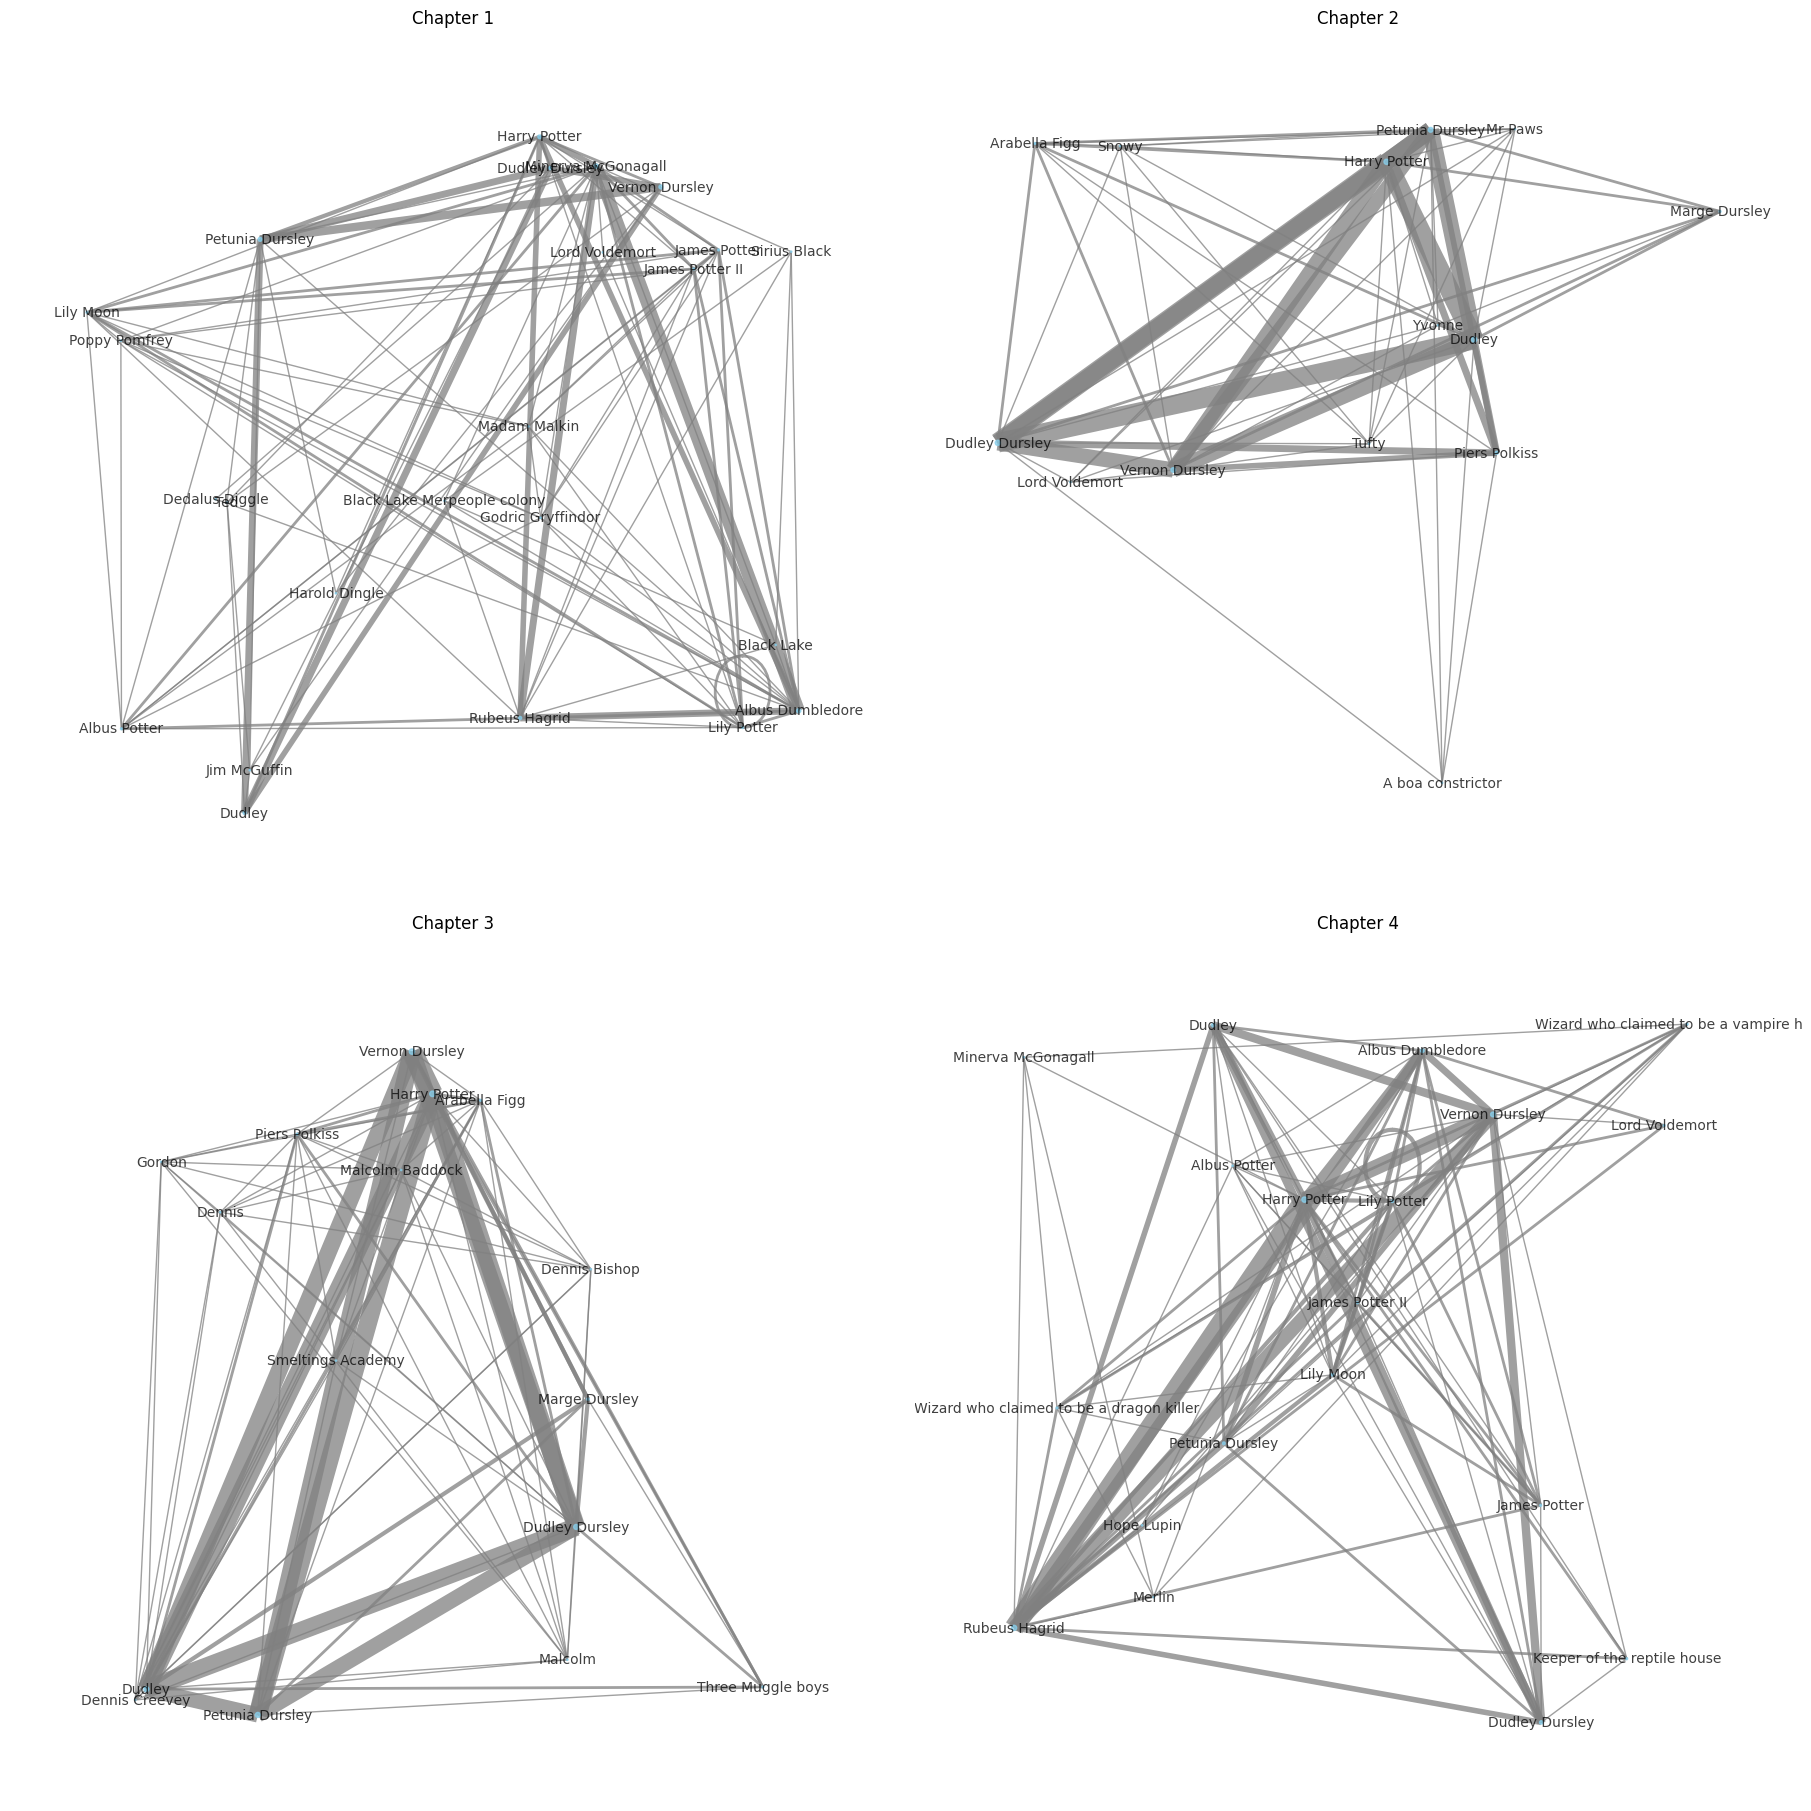

In [101]:
# draw network (random for starters)
# nw.visualize(G)
fig, axs = plt.subplots(2, 2, figsize=(18, 18), constrained_layout=True)

for chapternr in range(1,5):
    # Get node sizes
    node_sizes = [node[1]['sizes'][chapternr] for node in G.nodes.data()]

    # Get edge widths
    width = [edge[2]['weight'][chapternr] for edge in G.edges.data()]

    # Get labels
    labels = {}
    for node in G.nodes.data():
        if node[1]['sizes'][chapternr] != 0:
            labels.update({node[0]: node[0]})

    # plot
    nx.draw_random(G, node_size = node_sizes, width=width, edge_color = 'grey', node_color = 'skyblue', alpha = 0.75,
                   labels = labels, with_labels=True,
                   font_size=10, ax = axs[(chapternr-1)//2, (chapternr-1)%2])
    axs[(chapternr-1)//2, (chapternr-1)%2].set_title(f"Chapter {chapternr}")
plt.show()